# Data Wrangling with SQL Mountain View, Ca

## 2. Analyze the data with SQL and Pandas - Mountain View, California

##### Aviad Giat - Data Analyst Nano Degree Program, Udacity

After inspecting, auditing and improving the data on the first file ("Wrangle Openstreetmap Data - Inspect"), it's time to move on to deploy it into a new database, so it will be easier to do analysis on it.
Since this project is more about data wrangling than anything else, the analysis is basic and not going into depth.

#### About Mountain View
The California city of Mountain View, situated between the San Francisco Bay and the Santa Cruz Mountains, lies 10 miles north of San Jose and 35 miles south of San Francisco. Neighbouring cities include Palo Alto, Los Altos, and Sunnyvale. The city has 80,000 residents and its spread over 12 square miles.

#### Note!
Since the code became too long, I broke it into two different files. This file you are reading through is dealing with the CSV files and with the SQL database creation and analysis. The other file is the inspection, audit and improvement of the data. The same process of improving the data also exist on this file you are reading and can be found under "<a href="#export_csv">Fix and export the data to CSV files</a>" chapter below.

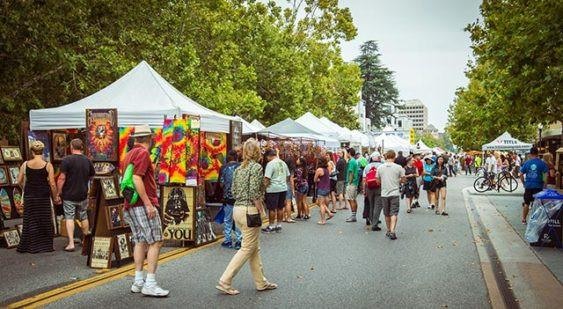

In [39]:
from IPython.display import Image
Image(filename='mountain_view_wine_festival.jpg')

<a id="top" name=""></a>
# Index
1. <a href="#export_csv">Fix and export the data to CSV files</a>
2. <a href="#create_sql">Create the SQL database</a>
3. <a href="#read_csv">Read the data from the CSV files</a>
4. <a href="#insert_data_sql">Insert the data into the SQL database</a>
5. <a href="#import_check">Check if the data was imported correctly to the SQL database</a>
6. <a href="#improve_sql">Improve data with SQL</a>
7. <a href="#analyze_sql">Analyze the data using SQL</a>
8. <a href="#analyze_pandas">Analyze the data using Pandas</a>
9. <a href="#conclusion">Conclusion</a>

In [14]:
%%html
<style>.output_wrapper, .output {height:auto !important; max-height:1000px;
                                }.output_scroll {box-shadow:none !important; webkit-box-shadow:none !important;}</style>

In [18]:
# Import relevant modules

import csv
import codecs
import pprint
import re
import xml.etree.cElementTree as ET
import cerberus

<a id="export_csv" name=""></a>
# Fix and export the data to CSV files
<a href="#top">Top</a>

In [19]:
# Fix and export the data to CSV files, before importing it into an SQL database
# Fix both street names and zip codes from above in one function

OSM_PATH = "mountain-view.osm"

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Alley","Plaza","Commons","Broadway","Expressway","Terrace","Center","Circle",
            "Crescent","Highway","Way", "Bruno", "Walk", "Corte"] 
            # Add new values to the street names' suffixes.

mapping = { "St": "Street",
            "St.": "Street",
            "Ave": "Avenue",
            "Ave.": "Avenue",
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "Dr": "Drive",
            "Dr.": "Drive",
            "Ct": "Court",
            "Ct.": "Court",
            "Pl": "Place",
            "Pl.": "Place",
            "Sq": "Square",
            "Sq.": "Square",
            "Ln": "Lane",
            "Ln.": "Lane",
            "Rd.": "Road",
            "Rd" : "Road",
            "Tr" : "Trail",
            "Tr.": "Trail",
            "Pkwy": "Parkway",
            "Pkwy.": "Parkway",
            "Hwy": "Highway",
            "NE": "Northeast",
           'NW': 'Northwest',
           'SW': 'Southwest',
           'SE': 'Southeast',
           'E': 'East',
           'W': 'West',
           'S': 'South',
           'N': 'North',
           'Ter': 'Terrace',
           'Corners': 'Cors',
           'Easst': 'East',
           'W.' : 'West',
            '#C': '',
            '#B': ''
            }

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

def fix_name(name, mapping):
    if "#" in name:
        street, *rest = name.split('#')
        name = street
    corrected_words = []
    words = name.split()  # Breaks a sentance into words on spaces
    for word in words:
        if word in mapping:
            correct_word = mapping[word]
        else:
            correct_word = word
        corrected_words.append(correct_word)
    name = " ".join(corrected_words)
    return name

def shape_element(element, zipcodes,node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  
    if element.tag == 'node':
        for attrib in element.attrib:
            if attrib in NODE_FIELDS:
                node_attribs[attrib] = element.attrib[attrib]
        for child in element:
            if child.attrib['k'] == "addr:postcode" and child.attrib['v'] not in zipcodes[1]: #Brings only correct ([1]) zip codes
                continue
            childValue = child.attrib['v']
            if child.attrib['k'] == "addr:street" : 
                childValue = fix_name(child.attrib['v'],mapping)
            node_tag = {}
#             if child.attrib['v'] != "Mountain View": # Pass any city tags that are not Mountain View
#                 continue
            if LOWER_COLON.match(child.attrib['k']):
                node_tag['type'] = child.attrib['k'].split(':',1)[0]
                node_tag['key'] = child.attrib['k'].split(':',1)[1]
                node_tag['id'] = element.attrib['id']
                node_tag['value'] = childValue
                tags.append(node_tag)
            elif PROBLEMCHARS.match(child.attrib['k']):
                continue
            else:
                node_tag['type'] = 'regular'
                node_tag['key'] = child.attrib['k']
                node_tag['id'] = element.attrib['id']
                node_tag['value'] = childValue
                tags.append(node_tag)
        return {'node': node_attribs, 'node_tags': tags}
    elif element.tag == 'way':
        for attrib in element.attrib:
            if attrib in WAY_FIELDS:
                way_attribs[attrib] = element.attrib[attrib]
        position = 0
        for child in element:
            way_tag = {}
            way_node = {}
            if child.tag == 'tag':
                if child.attrib['k'] == "addr:postcode" and child.attrib['v'] not in zipcodes[1]: #Brings only correct ([1]) zip codes
                    continue
                childValue = child.attrib['v']
                if child.attrib['k'] == "addr:street" : 
                    childValue = fix_name(child.attrib['v'],mapping) 
                if LOWER_COLON.match(child.attrib['k']):
                    way_tag['type'] = child.attrib['k'].split(':',1)[0]
                    way_tag['key'] = child.attrib['k'].split(':',1)[1]
                    way_tag['id'] = element.attrib['id']
                    way_tag['value'] = childValue
                    tags.append(way_tag)
                elif PROBLEMCHARS.match(child.attrib['k']):
                    continue
                else:
                    way_tag['type'] = 'regular'
                    way_tag['key'] = child.attrib['k']
                    way_tag['id'] = element.attrib['id']
                    way_tag['value'] = childValue
                    tags.append(way_tag)
            elif child.tag == 'nd':
                way_node['id'] = element.attrib['id']
                way_node['node_id'] = child.attrib['ref']
                way_node['position'] = position
                position += 1
                way_nodes.append(way_node)
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.items())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        raise Exception(message_string.format(field, error_string))

class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow(
            {k: str(v).encode('utf-8') for k, v in row.items()}
        )

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()
        zip_codes = audit_post("mountain-view.osm")
        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element,zip_codes)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])

if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    print("Starting")
    process_map(OSM_PATH, validate=False)
    print('Done!')

Starting
Done!


<a id="create_sql" name=""></a>
# Create the SQL database
<a href="#top">Top</a>

### Make new DB and drop tables if exist

In [20]:
# Relevant modules

import sqlite3
import csv

# Create a new database called "mountain_view"
sqlite_file = 'mountain_view.db'

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Create a cursor object
cur = conn.cursor()

# Drop tables if already exist
cur.execute('''DROP TABLE IF EXISTS nodes''')
cur.execute('''DROP TABLE IF EXISTS nodes_tags''')
cur.execute('''DROP TABLE IF EXISTS ways''')
cur.execute('''DROP TABLE IF EXISTS ways_tags''')
cur.execute('''DROP TABLE IF EXISTS ways_nodes''')
conn.commit()
print('Done!')

Done!


In [21]:
# Creating the tables (empty table for now)

QUERY_NODES = """
CREATE TABLE nodes (
    id INTEGER NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
);
"""

QUERY_NODES_TAGS = """
CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id)
);
"""

QUERY_WAYS = """
CREATE TABLE ways (
    id INTEGER NOT NULL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
);
"""

QUERY_WAYS_TAGS = """
CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways(id)
);
"""

QUERY_WAYS_NODES = """
CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways(id),
    FOREIGN KEY (node_id) REFERENCES nodes(id)
);
"""

cur.execute(QUERY_NODES)
cur.execute(QUERY_NODES_TAGS)
cur.execute(QUERY_WAYS)
cur.execute(QUERY_WAYS_TAGS)
cur.execute(QUERY_WAYS_NODES)

conn.commit()
print('Done!')

Done!


<a id="read_csv" name=""></a>
## Read the data from the CSV files
<a href="#top">Top</a>

In [24]:
# Reading the data from the csv fiels and temporarily format the data as a list of tuples

with open('nodes.csv','rt') as fin:
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db1 = [(i['id'], i['lat'], i['lon'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp']) for i in dr]
    
with open('nodes_tags.csv','rt') as fin:
    dr = csv.DictReader(fin)
    to_db2 = [(i['id'], i['key'], i['value'], i['type']) for i in dr]
    
with open('ways.csv','rt') as fin:
    dr = csv.DictReader(fin)
    to_db3 = [(i['id'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp']) for i in dr]
    
with open('ways_tags.csv','rt') as fin:
    dr = csv.DictReader(fin)
    to_db4 = [(i['id'], i['key'], i['value'], i['type']) for i in dr]
    
with open('ways_nodes.csv','rt') as fin:
    dr = csv.DictReader(fin)
    to_db5 = [(i['id'], i['node_id'], i['position']) for i in dr]
print('Done!')

Done!


<a id="insert_data_sql" name=""></a>
## Insert the data to the SQL database
<a href="#top">Top</a>

In [25]:
# Insert the above written data into the database
sqlite_file = 'mountain_view.db'

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Create a cursor object
cur = conn.cursor()

# Import the data into the respected table of the database
cur.executemany('INSERT INTO nodes(id, lat, lon, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?, ?, ?);', to_db1)
cur.executemany('INSERT INTO nodes_tags(id, key, value, type) VALUES (?, ?, ?, ?);', to_db2)
cur.executemany('INSERT INTO ways(id, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?);', to_db3)
cur.executemany('INSERT INTO ways_tags(id, key, value,type) VALUES (?, ?, ?, ?);', to_db4)
cur.executemany('INSERT INTO ways_nodes(id, node_id, position) VALUES (?, ?, ?);', to_db5)
print('Starting...')
conn.commit()
print('Done!')

Starting...
Done!


<a id="import_check" name=""></a>
# Check data import
<a href="#top">Top</a>

In [26]:
# check that the data was imported correctly

cur.execute("SELECT id, nodes_tags.value FROM nodes_tags WHERE key = 'city' LIMIT 10")
all_rows = cur.fetchall()
pprint.pprint(all_rows)

[(343135403, 'Mountain View'),
 (343268782, 'Mountain View'),
 (343588541, 'Mountain View'),
 (345438498, 'Los Altos'),
 (345476438, 'Mountain View'),
 (346427267, 'Mountain View'),
 (357600882, 'Mountain View'),
 (358838804, 'Sunnyvale'),
 (358838818, 'Sunnyvale'),
 (439492316, 'Mountain View')]


The data was not imported correctly, since there are other cities in the list above.
The solution is deleting every tag that is related to an 'id' that has its city value different than Mountain View.

<a id="improve_sql" name=""></a>
# Improve data with SQL
<a href="#top">Top</a>

## Remove records not related to Mountain View from the database

In [27]:
# delete non-Mountain View tags from nodes, ways, nodes_ways, ways_tags and ways_nodes tables using SQL:

cur.execute("DELETE FROM NODES WHERE id in (SELECT id FROM nodes_tags WHERE key = 'city' and value != 'Mountain View')")
cur.execute("DELETE FROM NODES_TAGS WHERE id in (SELECT id FROM nodes_tags WHERE key = 'city' and value != 'Mountain View')")
cur.execute("DELETE FROM WAYS WHERE id in (SELECT id FROM nodes_tags WHERE key = 'city' and value != 'Mountain View')")
cur.execute("DELETE FROM WAYS_TAGS WHERE id in (SELECT id FROM nodes_tags WHERE key = 'city' and value != 'Mountain View')")
cur.execute("DELETE FROM WAYS_NODES WHERE id in (SELECT id FROM nodes_tags WHERE key = 'city' and value != 'Mountain View')")

print('Done deleting')

Done deleting


In [28]:
# Verify that there are no records of cities that are not Mountain View:

cur.execute("SELECT id, nodes_tags.value FROM nodes_tags WHERE key = 'city' and value != 'Mountain View' limit 10")
all_rows = cur.fetchall()
pprint.pprint(all_rows)

print('\nThere is nothing to show.The database holds only Mountain View records now')


[]

There is nothing to show.The database holds only Mountain View records now


<a id="analyze_sql" name=""></a>
# Analyzing the data from the SQL database
<a href="#top">Top</a>

In [29]:
# Queries

sqlite_file = 'mountain_view.db'

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Create a cursor object
cur = conn.cursor()

def number_of_nodes():
    result = cur.execute('SELECT COUNT(*) FROM nodes')
    return result.fetchone()[0]

def number_of_ways():
    result = cur.execute('SELECT COUNT(*) FROM ways')
    return result.fetchone()[0]

def number_of_unique_users():
    result = cur.execute('SELECT COUNT(DISTINCT(e.uid)) \
            FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e')
    return result.fetchone()[0]
    
def number_of_users_contributing_once():
    result = cur.execute('SELECT COUNT(*) \
            FROM \
                (SELECT e.user, COUNT(*) as num \
                 FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e \
                 GROUP BY e.user \
                 HAVING num=1) u')
    return result.fetchone()[0]

def number_of_users_contributing_twice():
    result = cur.execute('SELECT COUNT(*) \
            FROM \
                (SELECT e.user, COUNT(*) as num \
                 FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e \
                 GROUP BY e.user \
                 HAVING num=2) u')
    return result.fetchone()[0]

def number_of_users_contributing_10_times():
    result = cur.execute('SELECT COUNT(*) \
            FROM \
                (SELECT e.user, COUNT(*) as num \
                 FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e \
                 GROUP BY e.user \
                 HAVING num=10) u')
    return result.fetchone()[0]

if __name__ == '__main__':
    con = sqlite3.connect("mountain_view.db")
    cur = con.cursor()
    print ("Number of nodes: " , number_of_nodes())
    print ("Number of ways: " , number_of_ways())
    print ("Number of unique users: " , number_of_unique_users())
    print ("Number of users contributing once: " , number_of_users_contributing_once())
    print ("Number of users contributing twice: ", number_of_users_contributing_twice())
    print ("Number of users contributing 10 times: ", number_of_users_contributing_10_times())

Number of nodes:  291999
Number of ways:  37291
Number of unique users:  530
Number of users contributing once:  112
Number of users contributing twice:  46
Number of users contributing 10 times:  7


In [30]:
# What is the most common religion?

def common_religion():
    for row in cur.execute('SELECT nodes_tags.value, COUNT(*) as num \
            FROM nodes_tags \
                JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value="place_of_worship") i \
                ON nodes_tags.id=i.id \
            WHERE nodes_tags.key="religion" \
            GROUP BY nodes_tags.value \
            ORDER BY num DESC \
            LIMIT 10;'):
        return row

print ("Most common religion: " , common_religion(), "places of worship")

Most common religion:  ('christian', 18) places of worship


In [31]:
# Common amenities in Mountain View
def common_ammenities():
    for row in cur.execute('SELECT value, COUNT(*) as num \
            FROM nodes_tags \
            WHERE key="amenity" \
            GROUP BY value \
            ORDER BY num DESC \
            LIMIT 10'):
        return row
print(common_ammenities())

('bicycle_parking', 238)


In [32]:
# Top contributing users

top_contrib_users = cur.execute('SELECT distinct(user), COUNT(*) as num \
            FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) \
            GROUP BY user \
            ORDER BY num DESC \
            LIMIT 10;')
print("10 top contributing users and the number of mentiones they appear in on the database\n")
pprint.pprint(top_contrib_users.fetchmany(10))

10 top contributing users and the number of mentiones they appear in on the database

[('ediyes', 46754),
 ('karitotp', 43024),
 ('RichRico', 24391),
 ('calfarome', 23045),
 ('samely', 22979),
 ('dannykath', 17332),
 ('Harry Cutts', 16793),
 ('Rub21', 11607),
 ('Luis36995', 11489),
 ('matthieun', 9353)]


In [33]:
# 5 most mentioned streets in Mountain View:
top_mentioned_streets = cur.execute('SELECT value, count(*) as num \
            FROM ways_tags \
            WHERE key="street" \
            group by value \
            order by num desc \
            limit 5 \
;')
print("5 most mentioned streets in Mountain View\n")
pprint.pprint(top_mentioned_streets.fetchmany(5))

5 most mentioned streets in Mountain View

[('Rock Street', 195),
 ('Sierra Vista Avenue', 145),
 ('San Luis Avenue', 117),
 ('Cuesta Drive', 107),
 ('Fordham Way', 102)]


<a id="analyze_pandas" name=""></a>
# Analizing the data using Pandas
<a href="#top">Top</a>

In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

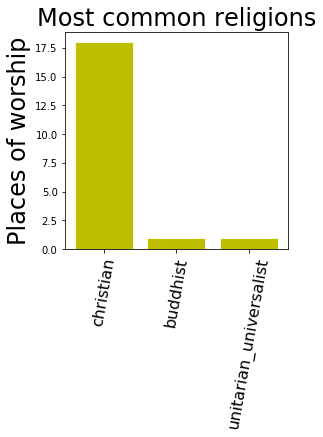

In [35]:
# Most common religions:

from pandas import DataFrame

sqlite_file = 'mountain_view.db'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

pop_religion = cur.execute('SELECT nodes_tags.value, COUNT(*) as num \
            FROM nodes_tags \
                JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value="place_of_worship") i \
                ON nodes_tags.id=i.id \
            WHERE nodes_tags.key="religion" \
            GROUP BY nodes_tags.value \
            ORDER BY num DESC \
            LIMIT 10;')
df_religion = DataFrame(pop_religion.fetchall())
df_religion.rename(columns={0: 'Religion', 1: 'Count'}, inplace=True)
df_religion

#Plot the data:

labels = list(df_religion['Religion'])
fig, ax = plt.subplots(figsize=(4,4))
ind = np.arange(3)
religion_count = ax.bar(ind, df_religion['Count'], width =0.8, color='y', edgecolor='w', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 80, size = 16)
plt.title('Most common religions', size = 24); plt.ylabel('Places of worship', size = 24);

This graph seems to be lacking other religions and places of worship. 
After researching a bit I found that there is a Muslim place of worship in Mountain View that is not mentioned in the OSM.
Nevertheless, I verified that there are 18 different churches in Mountain View with a simple Google search, which is the same number as in the OSM file I am working on and the one from the plot above. This means that the data does represent correctly the actual places of worship in Mountain View, with one exception.

            Cuisine  Count
0            indian     14
1          japanese     13
2             pizza     12
3           chinese     10
4           mexican     10
5     mediterranean      5
6             sushi      5
7          american      4
8             Asian      4
9        vietnamese      4
10           burger      3
11         sandwich      3
12             thai      3
13         barbecue      2
14          italian      2
15           korean      2
16  american;indian      1
17           bagels      1
18      boba;snacks      1
19        breakfast      1


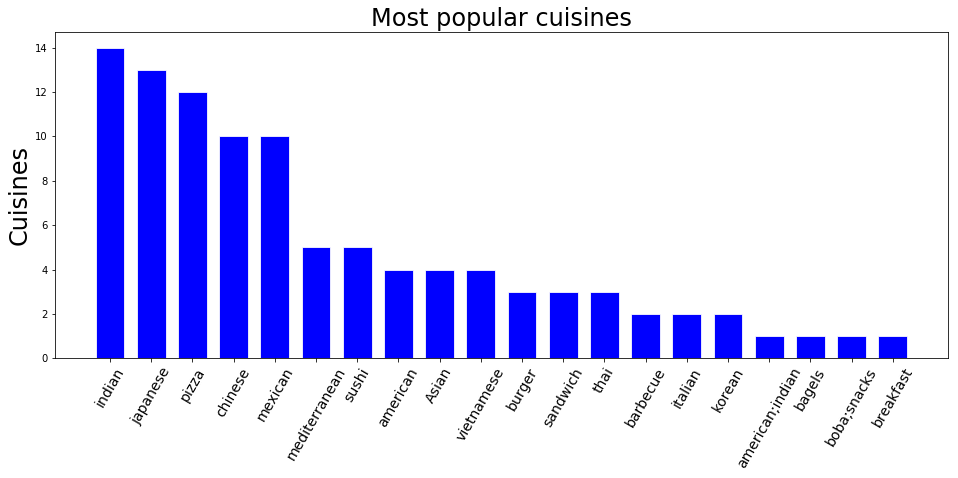

In [177]:
# Most popular cuisines

from pandas import DataFrame

sqlite_file = 'mountain_view.db'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

pop_cuisine = cur.execute('SELECT nodes_tags.value, COUNT(*) as num \
FROM nodes_tags \
JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value="restaurant") i \
ON nodes_tags.id=i.id \
WHERE nodes_tags.key="cuisine" \
GROUP BY LOWER(nodes_tags.value) \
ORDER BY num DESC limit 20')
df_cuisine = DataFrame(pop_cuisine.fetchall())
df_cuisine.rename(columns={0: 'Cuisine', 1: 'Count'}, inplace=True)
print(df_cuisine)

#Plot the data:

labels = list(df_cuisine['Cuisine'])

fig, ax = plt.subplots(figsize=(16,6))
ind = np.arange(20)
ax.bar(ind, df_cuisine['Count'], width =0.7, color='b', edgecolor='w', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 60, size = 14)
plt.title('Most popular cuisines', size = 24); plt.ylabel('Cuisines', size = 24);

Some records above repeat themselves, like Asian and asian, or Mexican and mexican. The solution was to group by LOWER caps with SQL, which make all appearances of the same tag become low caps and thus count them together.

            Amenity  Count
0   bicycle_parking    238
1             bench    163
2        restaurant    122
3              cafe     60
4         fast_food     36
5          post_box     33
6    drinking_water     29
7  parking_entrance     27
8          fountain     25
9           dentist     23


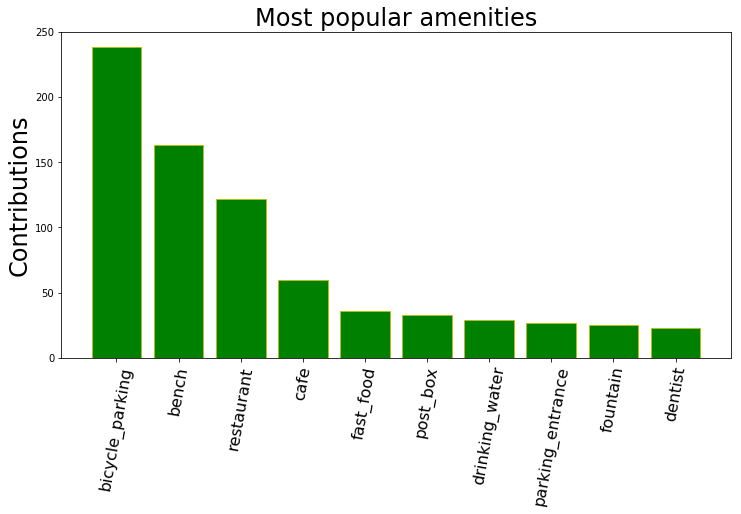

In [36]:
# Amenities

from pandas import DataFrame

sqlite_file = 'mountain_view.db'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

pop_amenity = cur.execute('SELECT value, COUNT(*) as num \
            FROM nodes_tags WHERE key="amenity" \
            GROUP BY value \
            ORDER BY num DESC \
            LIMIT 10;')
df_amenity = DataFrame(pop_amenity.fetchall())
df_amenity.rename(columns={0: 'Amenity', 1: 'Count'}, inplace=True)
pprint.pprint(df_amenity)

# Draw a plot

import matplotlib.pyplot as plt
import numpy as np

labels = list(df_amenity['Amenity'])

fig, ax = plt.subplots(figsize=(12,6))
ind = np.arange(10)
ax.bar(ind, df_amenity['Count'], width =0.8, color='g', edgecolor='y', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 80, size = 16)
plt.title('Most popular amenities', size = 24); plt.ylabel('Contributions', size = 24);

               User  Number of mentions
0            ediyes               89663
1          karitotp               83232
2          RichRico               46628
3         calfarome               44133
4            samely               43585
5         dannykath               33749
6       Harry Cutts               29162
7         Luis36995               22046
8             Rub21               21448
9         matthieun               17307
10            osmsf               16592
11            mk408               15531
12  nikhilprabhakar               13623
13            Apo42               12585
14              n76               10074
15      KindredCoda                6599
16     CoreyFarwell                6009
17           dbaupp                5984
18            beddy                5953
19         oldtopos                5158


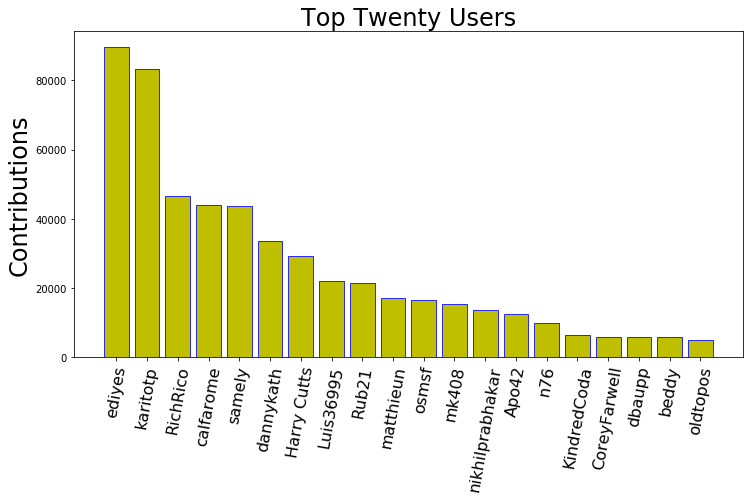

In [37]:
# Users Contributions

from pandas import DataFrame

sqlite_file = 'mountain_view.db'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

users = cur.execute('SELECT editer.user, count(*) as edits FROM \
(SELECT user FROM nodes \
 UNION ALL SELECT user FROM ways \
 UNION ALL SELECT user FROM nodes) as editer \
 GROUP BY editer.user \
 ORDER BY edits DESC \
 LIMIT 20')
df_users = DataFrame(users.fetchall())
df_users.rename(columns={0: 'User', 1: 'Number of mentions'}, inplace=True)
print(df_users)

labels = list(df_users['User'])

fig, ax = plt.subplots(figsize=(12,6))
ind = np.arange(20)
ax.bar(ind, df_users['Number of mentions'], width =0.8, color='y', edgecolor='b', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 80, size = 16)
plt.title('Top Twenty Users', size = 24); plt.ylabel('Contributions', size = 24);

<a id="conclusion" name=""></a>
# Conclusion
<a href="#top">Top</a>

This project was a great learning and practising data wrangling experience. I loved learning interesting facts about my city, like the fact that there is not one synagogue (compare to 3 in the neighbouring city of Palo Alto), and confirm things that I already knew, like the spread of Christian worship places.<br />

The Mountain View XML file with all its human-inserted data proved to be fairly complete one. For example, only 14 records were found with corrupted street names, of which 4 were false/negative cases. The same thing goes to the zip codes, where only 4 records were found to be wrong Mountain View zip codes, out of a couple of thousands found in the dataset.
Despite the fact that we saw only 3 different types of religion dominations places in Mountain View, this city's cultural diversity is much more colourful and flavorful, as it seen under the "Cuisine" analysis above. Indian restaurants, Japanese, Chinese, Pizza and Mexican can be found everywhere around the city and are the most popular. Even more than burger places, or American restaurants.


It seems that some users contributed an in-humane amount of data. For example, "ediyes" contributed 89,663 tags within the Nodes and Ways tags. The reason is that those users with that amount of data inserted are in actuality bots, which are operated by volunteers who wrote those scripts in order to reduce handwork, save time and increase accuracy. It works! The Mountain View OSM map has very few men made errors.

# Other ideas and improvements

#### Prevent Typos
A good way to prevent typos in streets and street types can be a function that checks every data inserted by the user and validates its accuracy. For example, if a user inserts "Mont Blanc Rd.", the function will recognize the incomplete suffix of the street name and automatically correct it to "Road". Just like we did in the above code of the street names and zip codes, using mapping.
What can go wrong with this typos-prevention method is suffixes that the system does not recognize as ones, thus not correcting them when there are human errors with those unknown suffixes. So, it won't fix everything all the time. The positive thing here is that with time more and more suffixes will be added to the OSM database, so the auto-correction will improve.

#### Lowercase them all!
Another improvement can be done on the Open Street Map code to make all certain tags' values (for example, the tag "Cuisine", as shown above under "Most Popular Cuisine" code snippet) uppercase or lowercase, but not mixed. This can save work to the analyst using the data.
An interesting point to think about is if this improvement is necessary for other languages and how well it will fit ones that are not Latin. Maybe there is no need for that functionality with other languages at all.
Another point to think about here is the visibility of the data to the end user. It is much easier to recognize and understand the meaning of a word that is capitalized since they can suggest a proper noun name, a specific person, or a place. To do that in the code above it is easy as changing the LOWER SQL command to UPPER. Naturally, the better solution would be to work on this issue on the OSM code itself, so when it gets to the users, it is already uniformed.